In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go
#offline.init_notebook_mode()
from collections import Counter

In [2]:
preprocessed_data = pd.read_csv('preprocessed_data.csv')

In [3]:
preprocessed_data.head(2)
preprocessed_data.shape

(109248, 16)

In [4]:
preprocessed_data=preprocessed_data.iloc[:50000,:]


In [5]:
preprocessed_data.shape

(50000, 16)

# Splitting data into X & Y

In [6]:
y = preprocessed_data['project_is_approved'].values
x = preprocessed_data.drop(['project_is_approved'], axis=1)
x.head(1)

,Unnamed: 0,teacher_prefix,project_grade_category,project_subject_subcategories,teacher_number_of_previously_posted_projects,year_month,cleaned_subjects,ppd_essays,ppd_res_summary,price,quantity,essay_word_count,title_word_count,ppd_titles,school_state
0,41656,mrs,grades_6_8,Literature_Writing & Special_Needs,11,17-03,Literacy_Language & Special_Needs,remember given work independently seat teacher...,students need reading kits reading writing ski...,343.97,10,240,6,i do we do you do,il


# Splitting data into Train & Test data (No need for sep. CV because we are doing N-fold Grid Search CV)

In [7]:
print(y)
print(type(y))
y.size

[0 0 0 ... 1 0 1]
<class 'numpy.ndarray'>


50000

In [8]:
from sklearn.model_selection import train_test_split
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.33, stratify=y)

print(y_tr.size)
print(y_te.size)
print(x_tr.shape)
print(x_te.shape)

33500
16500
(33500, 15)
(16500, 15)


# Vectorization - Essay, Project_title, Project Summary

In [9]:
vectorizer = CountVectorizer(min_df=20,ngram_range=(1,3))
vectorizer.fit(x_tr['ppd_essays'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
x_tr_essay_bow = vectorizer.transform(x_tr['ppd_essays'].values)
x_te_essay_bow = vectorizer.transform(x_te['ppd_essays'].values)

print("After vectorizations")
print(x_tr_essay_bow.shape, y_tr.shape)
print(x_te_essay_bow.shape, y_te.shape)

After vectorizations
(33500, 43209) (33500,)
(16500, 43209) (16500,)


In [10]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['ppd_titles'].values) # fit has to happen only on train data

x_tr_title_bow = vectorizer.transform(x_tr['ppd_titles'].values)
x_te_title_bow = vectorizer.transform(x_te['ppd_titles'].values)

print("After vectorizations")
print(x_tr_title_bow.shape, y_tr.shape)
print(x_te_title_bow.shape, y_te.shape)

After vectorizations
(33500, 9293) (33500,)
(16500, 9293) (16500,)


In [11]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['ppd_res_summary'].values)

x_tr_res_summary_bow = vectorizer.transform(x_tr['ppd_res_summary'].values)
x_te_res_summary_bow = vectorizer.transform(x_te['ppd_res_summary'].values)

print("After vectorizations")
print(x_tr_res_summary_bow.shape, y_tr.shape)
print(x_te_res_summary_bow.shape, y_te.shape)

After vectorizations
(33500, 13740) (33500,)
(16500, 13740) (16500,)


In [12]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['cleaned_subjects'].values)

x_tr_subjects_ohe = vectorizer.transform(x_tr['cleaned_subjects'].values)
x_te_subjects_ohe = vectorizer.transform(x_te['cleaned_subjects'].values)

print("After vectorizations")
print(x_tr_subjects_ohe.shape, y_tr.shape)
print(x_te_subjects_ohe.shape, y_te.shape)

After vectorizations
(33500, 9) (33500,)
(16500, 9) (16500,)


In [13]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['project_subject_subcategories'].values)

x_tr_subject_subcat_ohe = vectorizer.transform(x_tr['project_subject_subcategories'].values)
x_te_subject_subcat_ohe = vectorizer.transform(x_te['project_subject_subcategories'].values)

print("After vectorizations")
print(x_tr_subject_subcat_ohe.shape, y_tr.shape)
print(x_te_subject_subcat_ohe.shape, y_te.shape)

After vectorizations
(33500, 30) (33500,)
(16500, 30) (16500,)


# Vectorization of Categorical features

In [14]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['school_state'].values) # fit has to happen only on train data

x_tr_state_ohe = vectorizer.transform(x_tr['school_state'].values)
x_te_state_ohe = vectorizer.transform(x_te['school_state'].values)

print("After vectorizations")
print(x_tr_state_ohe.shape, y_tr.shape)
print(x_te_state_ohe.shape, y_te.shape)

After vectorizations
(33500, 51) (33500,)
(16500, 51) (16500,)


In [15]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['teacher_prefix'].values) # fit has to happen only on train data

x_tr_tprefix_ohe = vectorizer.transform(x_tr['teacher_prefix'].values)
x_te_tprefix_ohe = vectorizer.transform(x_te['teacher_prefix'].values)

print("After vectorizations")
print(x_tr_tprefix_ohe.shape, y_tr.shape)
print(x_te_tprefix_ohe.shape, y_te.shape)

After vectorizations
(33500, 5) (33500,)
(16500, 5) (16500,)


In [16]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['project_grade_category'].values) # fit has to happen only on train data

x_tr_grade_ohe = vectorizer.transform(x_tr['project_grade_category'].values)
x_te_grade_ohe = vectorizer.transform(x_te['project_grade_category'].values)

print("After vectorizations")
print(x_tr_grade_ohe.shape, y_tr.shape)
print(x_te_grade_ohe.shape, y_te.shape)

After vectorizations
(33500, 4) (33500,)
(16500, 4) (16500,)


# Normalization - Price, Quantity, Previous Projects, Word_counts

In [17]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(x_tr['price'].values.reshape(-1,1))

x_tr_price_norm = normalizer.transform(x_tr['price'].values.reshape(-1,1))
x_te_price_norm = normalizer.transform(x_te['price'].values.reshape(-1,1))

print("After vectorizations")
print(x_tr_price_norm.shape, y_tr.shape)
print(x_te_price_norm.shape, y_te.shape)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


In [18]:
normalizer = Normalizer()
normalizer.fit(x_tr['quantity'].values.reshape(-1,1))

x_tr_quantity_norm = normalizer.transform(x_tr['quantity'].values.reshape(-1,1))
x_te_quantity_norm = normalizer.transform(x_te['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(x_tr_quantity_norm.shape, y_tr.shape)
print(x_te_quantity_norm.shape, y_te.shape)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


In [19]:
normalizer = Normalizer()
normalizer.fit(x_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

x_tr_prev_projects_norm = normalizer.transform(x_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_te_prev_projects_norm = normalizer.transform(x_te['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(x_tr_prev_projects_norm.shape, y_tr.shape)
print(x_te_prev_projects_norm.shape, y_te.shape)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


In [20]:
normalizer = Normalizer()
normalizer.fit(x_tr['essay_word_count'].values.reshape(-1,1))

x_tr_essay_word_count_norm = normalizer.transform(x_tr['essay_word_count'].values.reshape(-1,1))
x_te_essay_word_count_norm = normalizer.transform(x_te['essay_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(x_tr_essay_word_count_norm.shape, y_tr.shape)
print(x_te_essay_word_count_norm.shape, y_te.shape)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


In [21]:
normalizer = Normalizer()
normalizer.fit(x_tr['title_word_count'].values.reshape(-1,1))

x_tr_title_word_count_norm = normalizer.transform(x_tr['title_word_count'].values.reshape(-1,1))
x_te_title_word_count_norm = normalizer.transform(x_te['title_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(x_tr_title_word_count_norm.shape, y_tr.shape)
print(x_te_title_word_count_norm.shape, y_te.shape)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


# Stacking of vectors

In [22]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((x_tr_essay_bow, x_tr_title_bow, x_tr_res_summary_bow, x_tr_subjects_ohe, x_tr_subject_subcat_ohe.shape, x_tr_state_ohe.shape, x_tr_tprefix_ohe.shape, x_tr_grade_ohe, x_tr_price_norm, x_tr_quantity_norm, x_tr_prev_projects_norm, x_tr_essay_word_count_norm, x_tr_title_word_count_norm)).tocsr()
X_te = hstack((x_te_essay_bow, x_te_title_bow, x_te_res_summary_bow, x_te_subjects_ohe, x_te_subject_subcat_ohe.shape, x_te_state_ohe.shape, x_te_tprefix_ohe.shape, x_te_grade_ohe, x_te_price_norm, x_te_quantity_norm, x_te_prev_projects_norm, x_te_essay_word_count_norm, x_te_title_word_count_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_tr.shape)
print(X_te.shape, y_te.shape)

Final Data matrix
(33500, 66346) (33500,)
(16500, 66346) (16500,)


In [23]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

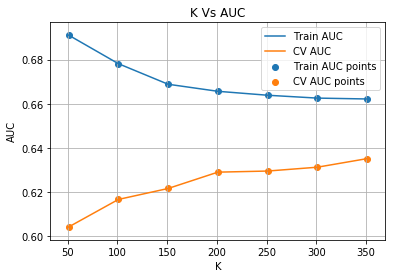

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.092665,0.014075,13.977168,0.682865,51,{'n_neighbors': 51},0.601247,0.592956,0.618616,0.604273,0.010692,7,0.691010,0.689073,0.693167,0.691083,0.001672
1,0.088510,0.007357,14.514852,0.062380,101,{'n_neighbors': 101},0.618460,0.606617,0.625115,0.616731,0.007650,6,0.677604,0.675960,0.680952,0.678172,0.002077
2,0.088521,0.007365,14.656367,0.082140,151,{'n_neighbors': 151},0.622195,0.614793,0.628081,0.621690,0.005437,5,0.667127,0.664247,0.675212,0.668862,0.004642
3,0.093733,0.012757,14.658675,0.044710,201,{'n_neighbors': 201},0.625419,0.625254,0.636568,0.629080,0.005295,4,0.667904,0.660039,0.669078,0.665674,0.004013
4,0.088520,0.007365,14.893288,0.104142,251,{'n_neighbors': 251},0.624398,0.625572,0.638770,0.629580,0.006516,3,0.667408,0.658318,0.665935,0.663887,0.003984


In [24]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

neigh = KNeighborsClassifier(n_jobs=-1)
parameters = {'n_neighbors':[51, 101,151,201,251,301,351]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(X_tr, y_tr)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_n_neighbors']

plt.plot(K, train_auc, label='Train AUC')

plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K")
plt.ylabel("AUC")
plt.title("K Vs AUC")
plt.grid()
plt.show()

results.head()

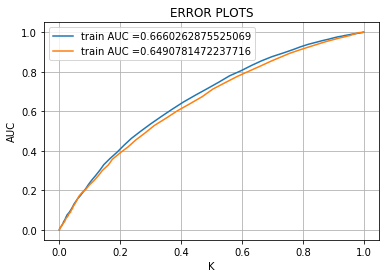

In [26]:
from sklearn.metrics import roc_curve, auc

neigh = KNeighborsClassifier(n_neighbors=351, n_jobs=-1)
neigh.fit(X_tr, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

#y_tr_pred = neigh.predict_proba(X_tr)   
#y_te_pred = neigh.predict_proba(X_te)

y_tr_pred = batch_predict(neigh, X_tr)    
y_te_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_tr, y_tr_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_te, y_te_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [28]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    print("50*=")
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print(50*"=")
print("Train confusion matrix")
print(confusion_matrix(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test confusion matrix")
print(confusion_matrix(y_te, predict_with_best_t(y_te_pred, best_t)))
print(50*"=")
print("Train F1 Score")
print(f1_score(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test F1 Score")
print(f1_score(y_te, predict_with_best_t(y_te_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.384082344473777 for threshold 0.792
Train confusion matrix
[[ 3207  1891]
 [11061 17341]]
Test confusion matrix
[[1534  977]
 [5543 8446]]
Train F1 Score
0.7280933786790948
Test F1 Score
0.7215103365795319


# Naive Bayes

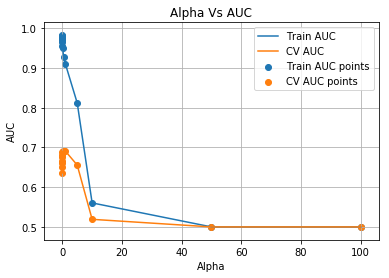

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.122405,0.021176,0.031313,0.006377,1e-05,{'alpha': 1e-05},0.631978,0.639576,0.636652,0.636068,0.003129,11,0.982104,0.983197,0.983350,0.982884,0.000555
2,0.104935,0.015849,0.018823,0.003505,0.0001,{'alpha': 0.0001},0.649517,0.653993,0.649922,0.651144,0.002021,10,0.979096,0.980212,0.980433,0.979914,0.000585
1,0.120922,0.021401,0.021550,0.006910,0.0005,{'alpha': 0.0005},0.660567,0.662146,0.660853,0.661189,0.000687,8,0.976001,0.977102,0.977396,0.976833,0.000601
4,0.114100,0.012202,0.023874,0.006408,0.001,{'alpha': 0.001},0.664742,0.667080,0.665810,0.665877,0.000956,7,0.974276,0.975372,0.975706,0.975118,0.000611
3,0.107314,0.006167,0.022277,0.004854,0.005,{'alpha': 0.005},0.675083,0.679060,0.676384,0.676842,0.001655,6,0.968893,0.969992,0.970444,0.969776,0.000651


In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

nb = MultinomialNB()
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
clf = GridSearchCV(nb, parameters, cv=3, scoring='roc_auc')
clf.fit(X_tr, y_tr)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
alp =  results['param_alpha']

plt.plot(alp, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alp, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alp, train_auc, label='Train AUC points')
plt.scatter(alp, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("Alpha Vs AUC")
plt.grid()
plt.show()

results.head()